Deep Learning With Python - Robert Chollet ,(Chapter 9 - Advanced deep learning for computer vision)

##  An image segmentation example

In [ ]:
#Image segmentation in deep learning is about using a model to attribute a class to each pixel in an image
#thus segmenting the image into different zones(such as 'background', 'car', 'cat')

###There are two different flavors of image segmentation that you should know about:

*   Semantic segmentation, where each pixel is independently classified into a semantic category, like “cat.” If there are two cats in the image, the corresponding pixels are all mapped to the same generic “cat” category

*   Instance segmentation, which seeks not only to classify image pixels by category,
  but also to parse out individual object instances. In an image with two cats in it,
  instance segmentation would treat “cat 1” and “cat 2” as two separate classes of
  pixels 

In this example, we’ll focus on semantic segmentation: we’ll be looking once again at
images of cats and dogs, and this time we’ll learn how to tell apart the main subject
and its background.

 We’ll work with the Oxford-IIIT Pets [dataset](www.robots.ox.ac.uk/~vgg/data/pets/), which contains 7,390 pictures of various breeds of cats and dogs, together with
foreground-background segmentation masks for each picture. A segmentation mask is
the image-segmentation equivalent of a label: it’s an image the same size as the input
image, with a single color channel where each integer value corresponds to the class
of the corresponding pixel in the input image. In our case, the pixels of our segmentation masks can take one of three integer values:

*  1 (foreground)
*  2 (background)
*  3 (contour


In [ ]:
##download and unzip the dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-11-17 10:55:20--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2022-11-17 10:55:21--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-11-17 10:55:21--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7

In [ ]:
#The input pictures are stored as JPG files in the images/ folder (such as images/Abyssinian_1.jpg), and the corresponding segmentation mask is stored as a PNG file with
#the same name in the annotations/trimaps/ folder (such as annotations/trimaps/Abyssinian_1.png).

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")]
)

In [ ]:
len(input_img_paths)

7390

In [ ]:
target_paths = sorted(
  [os.path.join(target_dir, fname)
  for fname in os.listdir(target_dir)
  if fname.endswith(".png") and not fname.startswith(".")])

len(target_paths)

7390

In [ ]:
#Now, what does one of these inputs and its mask look like? Let’s take a quick look.
#Here’s a sample image

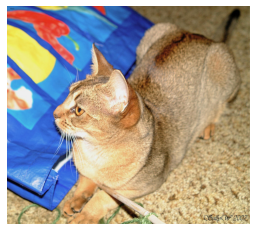

In [ ]:
import matplotlib.pyplot as plt 
from tensorflow.keras.utils import load_img, img_to_array
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

In [ ]:
#And here is its corresponding target

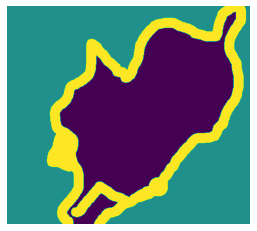

In [ ]:
def display_target(target_array):
  normalized_array = (target_array.astype("uint8") - 1) * 127 
  plt.axis("off")
  plt.imshow(normalized_array[:, :, 0])
img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) 
display_target(img)

In [ ]:
import numpy as np 
import random 

img_size = (200, 200) 
num_imgs = len(input_img_paths) 

random.Random(1337).shuffle(input_img_paths) 
random.Random(1337).shuffle(target_paths) 

def path_to_input_image(path):
  return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
 img = img_to_array(
 load_img(path, target_size=img_size, color_mode="grayscale"))
 img = img.astype("uint8") - 1 
 return img


input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") 
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8") 

for i in range(num_imgs): 
  input_imgs[i] = path_to_input_image(input_img_paths[i]) 
  targets[i] = path_to_target(target_paths[i])

In [ ]:
num_val_samples = 1000 
train_input_imgs = input_imgs[:-num_val_samples] 
train_targets = targets[:-num_val_samples] 
val_input_imgs = input_imgs[-num_val_samples:] 
val_targets = targets[-num_val_samples:]

In [ ]:
#Now it’s time to define our model:


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

def get_model(img_size, num_classes):
  inputs = keras.Input(shape= img_size + (3,))

  x = layers.Rescaling(1./255)(inputs)

  x = layers.Conv2D(64, 3, strides=2, activation='relu', padding = 'same')(x)

  x = layers.Conv2D(64, 3,  activation='relu', padding = 'same')(x)

  x = layers.Conv2D(128, 3, strides=2, activation='relu', padding = 'same')(x)

  x = layers.Conv2D(128, 3,  activation='relu', padding = 'same')(x)

  x = layers.Conv2D(256, 3, strides=2, activation='relu', padding = 'same')(x)

  x = layers.Conv2D(256, 3, activation='relu', padding = 'same')(x)

  

  x = layers.Conv2DTranspose(256, 3, activation='relu', padding='same')(x)

  x = layers.Conv2DTranspose(256, 3, strides=2 , activation='relu', padding = 'same')(x)

  x = layers.Conv2DTranspose(128, 3, activation= 'relu', padding = 'same')(x)

  x = layers.Conv2DTranspose(128, 3, activation= 'relu', padding = 'same' , strides = 2)(x)

  x = layers.Conv2DTranspose(64, 3, activation = 'relu', padding = 'same')(x)

  x = layers.Conv2DTranspose(64, 3, activation= 'relu', padding='same', strides = 2)(x)

  outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding = "same")(x)

  model = keras.Model(inputs, outputs)

  return model

In [ ]:
model = get_model(img_size, 3)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

In [ ]:
##let's compile and train the model now

model.compile(loss='sparse_categorical_crossentropy',
              optimizer = 'rmsprop')

In [ ]:
callbacks = [
 keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
 save_best_only=True)
]

In [ ]:
history = model.fit(train_input_imgs, train_targets,
  epochs=50,
  callbacks=callbacks,
  batch_size=64,
  validation_data=(val_input_imgs, val_targets))

Epoch 1/50
100/100 [==============================] - 83s 672ms/step - loss: 5.9314 - val_loss: 0.8523
Epoch 2/50
100/100 [==============================] - 60s 597ms/step - loss: 0.8498 - val_loss: 0.8912
Epoch 3/50
100/100 [==============================] - 60s 597ms/step - loss: 0.8197 - val_loss: 0.7927
Epoch 4/50
100/100 [==============================] - 60s 596ms/step - loss: 0.7812 - val_loss: 0.7164
Epoch 5/50
100/100 [==============================] - 60s 598ms/step - loss: 0.7218 - val_loss: 0.7476
Epoch 6/50
100/100 [==============================] - 60s 597ms/step - loss: 0.6671 - val_loss: 0.6046
Epoch 7/50
100/100 [==============================] - 60s 597ms/step - loss: 0.6405 - val_loss: 0.8751
Epoch 8/50
100/100 [==============================] - 60s 598ms/step - loss: 0.6070 - val_loss: 0.5574
Epoch 9/50
100/100 [==============================] - 60s 598ms/step - loss: 0.5767 - val_loss: 0.5346
Epoch 10/50
100/100 [==============================] - 60s 598ms/step - l

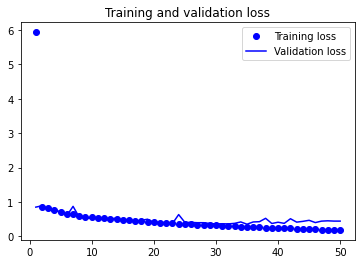

In [ ]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()


1/1 [==============================] - 0s 170ms/step


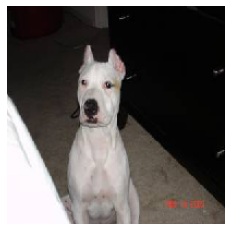

In [ ]:
from tensorflow.keras.utils import array_to_img
model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))
mask = model.predict(np.expand_dims(test_image, 0))[0]



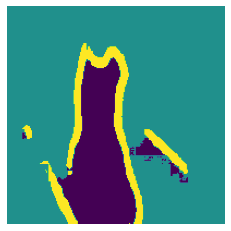

In [ ]:
def display_mask(pred): 
 mask = np.argmax(pred, axis=-1)
 mask *= 127
 plt.axis("off")
 plt.imshow(mask)
display_mask(mask)